In [1]:
import sys
sys.path.append("../scripts/")
from gridmap import *
from matplotlib.animation import PillowWriter    #アニメーション保存用
import math
import random
import copy

In [2]:
class RRT():
    def __init__(self, grid_map_world, ratioPointGoal=0.9, drawVertex=False):    
        self.world = grid_map_world
        self.grid_map = grid_map_world.grid_map
        self.vertex = []    #[x, y, cost]
        self.edge = []  #[id1, id2]
        self.candidate = []
        self.parent = []    #[x, y]
        self.id = []    #[x, y]
        self.isStart = True
        self.isFinish = False
        self.isPathDraw = False
        self.ratePointGoal = ratioPointGoal
        self.marker_size = 4
        self.start_cordinate = [(self.world.start_index[0]+1/2)*self.world.grid_step[0], (self.world.start_index[1]+1/2)*self.world.grid_step[1]]
        self.goal_cordinate = [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        self.drawVertexflag = drawVertex
    
    def draw(self, ax, elems):
        xs, xn, xp = self.RRT()
        
        self.drawEdge(ax, elems)    #全エッジを描画
        if(self.drawVertexflag):
            self.drawVertex(ax, elems)    #全頂点を描画
        if(not(self.isFinish)):
            self.drawSamplingPoint(ax, elems, xs)    #サンプリング点を描画
            self.drawExtendedEdge(ax, elems, xn, xp)    #拡張したエッジを描画
        self.drawPath(ax, elems)    #得られた経路の描画
    
    def RRT(self):
        if(self.isFinish):
            return None, None, None       
        if(self.isStart):
            x, y = self.start_cordinate
            self.vertex.append([x, y, 0.0])
            self.parent.append(0)
            self.isStart = False
            self.id.append([x, y])   
        xn, yn = None, None
        xp, yp = None, None
        xp_n, yp_n = None, None
        cost_n = None
        nearest_id = None
        isFindVertex = False
        while(isFindVertex == False):    #結べる点が得られるまで繰り返す
            #サンプリング
            if(random.random() > self.ratePointGoal and not(self.isFinish)):
                xp, yp = self.goal_cordinate    #ある確率でゴールを選択する
            else:
                r1 = random.random()
                r2 = random.random()
                xp = self.world.grid_num[0]*self.world.grid_step[0]*r1
                yp = self.world.grid_num[1]*self.world.grid_step[1]*r2
                xp, yp = self.returnGoalGrid([xp, yp])
            
            #新しい点を探し，衝突確認を行う
            candidate = copy.copy(self.vertex)
            while(1):
                xn, yn, xp_n, yp_n, cost_n, nearest_id = self.getNearestVertex([xp, yp], candidate)    #[xp, yp]に最も近い頂点を探索
                if(self.isGoal([xn, yn])):
                    [xn, yn] = self.goal_cordinate
                    isFindVertex = True
                    self.isFinish = True
                    break
                #隣接ノードと半径1.1 grid_step以内であれば除外する
                #障害物に当たったりマップ外に出たりした場合はxn=xp_n, yn=yp_n
                if(math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2) < 0.001*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                    candidate.pop(nearest_id)
                    if(candidate == []):
                        break
                else:
                    isFindVertex = True
                    break
        
        cost_new = cost_n + math.sqrt((xn-xp_n)**2 + (yn-yp_n)**2)
        self.vertex.append([xn, yn, cost_new])
        self.edge.append([xn, yn, xp_n, yp_n])
        self.parent.append([xp_n, yp_n])
        self.id.append([xn, yn])
        return [xp, yp], [xn, yn], [xp_n, yp_n]    #サンプリング点，新しい点，ペアレント点を返す
    
    #最も近い頂点を探し，2つの頂点の座標とコストを返す
    def getNearestVertex(self, xNew, candidate):
        dis = float('inf')
        dis_collision = float('inf')
        xNearest = []
        xNearest_collision = []
        cost_n = 0
        cost_n_collision = 0
        nearest_id = 0
        nearest_id_collision = 0
        for x in candidate:
            collision = 1
            #collision, _, _ = self.collisionFree(x, xNew, type2=False)
            if(collision == 1):
                if(dis > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest = [x[0], x[1]]
                    cost_n = x[2]
                    nearest_id = candidate.index([x[0], x[1], x[2]])
            elif(collision == 0):
                if(dis_collision > (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2 and xNew != x):
                    dis_collision = (xNew[0]-x[0])**2 + (xNew[1]-x[1])**2
                    xNearest_collision = [x[0], x[1]]
                    cost_n_collision = x[2]
                    nearest_id_collision = candidate.index([x[0], x[1], x[2]])
                    
        if(xNearest == []):
            xNearest = xNearest_collision
            cost_n_collision = cost_n
            nearest_id = nearest_id_collision
        
        isCollision = self.collisionFree(xNearest, xNew, type2=True)
        if(isCollision[0] == 0):
            return xNearest[0], xNearest[1], xNearest[0], xNearest[1], cost_n, nearest_id
        elif(isCollision[0] == 2):
            return isCollision[1], isCollision[2], xNearest[0], xNearest[1], cost_n, nearest_id
        else:
            return xNew[0], xNew[1], xNearest[0], xNearest[1], cost_n, nearest_id
    
    #x1, x2の間が障害物で挟まれていないか
    def collisionFree(self, x1, x2, type2=True):
        dx = x2[0] - x1[0]
        dy = x2[1] - x1[1]
        dr = dx**2 + dy**2
        x_next = x1
        #x1から少しずつ伸ばし，障害物があるか確認する
        while(math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) < math.sqrt((x1[0]-x2[0])**2+(x1[1]-x2[1])**2)):
            x_next = [x_next[0]+self.world.grid_step[0]*0.01*dx/dr, x_next[1]+self.world.grid_step[0]*0.01*dy/dr]
            if(self.isObstacle(x_next)):
                return [0, x1[0], x1[1]]    #障害物に挟まれている場合
            if((self.isGoal(x_next) and not(self.isGoal(x1)) and not(self.isGoal(x2))) and type2):
                return [1, self.goal_cordinate[0], self.goal_cordinate[1]]
            if(type2 and math.sqrt((x_next[0]-x1[0])**2+(x_next[1]-x1[1])**2) > 2*math.sqrt(self.world.grid_step[0]**2+self.world.grid_step[1]**2)):
                return [2, x_next[0], x_next[1]]    #障害物に挟まれていないが，一定距離で制限しその点を返す
        return [1, x2[0], x2[1]]    #直接結んでも障害物に挟まれていない
    
    def isObstacle(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return True    #マップ外なら障害物とする
        if(self.grid_map[x_num][y_num] == '0'):
            return True    #障害物の場合
        else:
            return False

    def isGoal(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return False
        if(self.grid_map[x_num][y_num] == '3'):
            return True
        else:
            return False
        
    #ゴールのグリッドの中ならゴールの座標を返す
    def returnGoalGrid(self, x):
        x_num = math.floor(x[0]/self.world.grid_step[0])
        y_num = math.floor(x[1]/self.world.grid_step[1])
        if(x_num >= self.world.grid_num[0] or y_num >= self.world.grid_num[1] or x_num < 0 or y_num < 0):
            return [0, 0]
        if(self.grid_map[x_num][y_num] == '3'):
            return [(self.world.goal_index[0]+1/2)*self.world.grid_step[0], (self.world.goal_index[1]+1/2)*self.world.grid_step[1]]
        else:
            return x 
    
    #id取得
    def get_id(self, x):
        return self.id.index(x)
    
    def drawVertex(self, ax, elems):
        for x in self.vertex:
            elems += ax.plot(x[0], x[1], marker='.', markersize=self.marker_size, color="Blue")
    
    def drawEdge(self, ax, elems):
        for edge in self.edge:
            x1, y1, x2, y2 = edge
            elems += ax.plot([x1, x2], [y1, y2], color="cyan", alpha=1.0)
            
    def drawExtendedEdge(self, ax, elems, x1, x2):
        elems += ax.plot([x1[0], x2[0]], [x1[1], x2[1]], color="blue", alpha=0.5)        
    
    def drawSamplingPoint(self, ax, elems, x):
        elems += ax.plot(x[0], x[1], marker='.', color="red")
    
    def drawPath(self, ax, elems):
        if(self.isFinish):
            #ゴールからスタート
            id = self.get_id(self.goal_cordinate)
            distance = 0
            while(id != 0):    #スタート（id=0）になるまで繰り返す
                x1, y1 = self.id[id]
                x2, y2 = self.parent[id]
                id = self.get_id([x2, y2])
                elems += ax.plot([x1, x2], [y1, y2], color="red")
                distance += math.sqrt((x1-x2)**2 + (y1-y2)**2)
            dis_str ="Distance = %.4f" % (distance)
            elems.append(
                ax.text(
                    self.world.grid_step[0]*self.world.grid_num[0]*0.6,
                    self.world.grid_step[1]*self.world.grid_num[1]*1.02,
                    dis_str,
                    fontsize=10
                )
            )

<IPython.core.display.Javascript object>


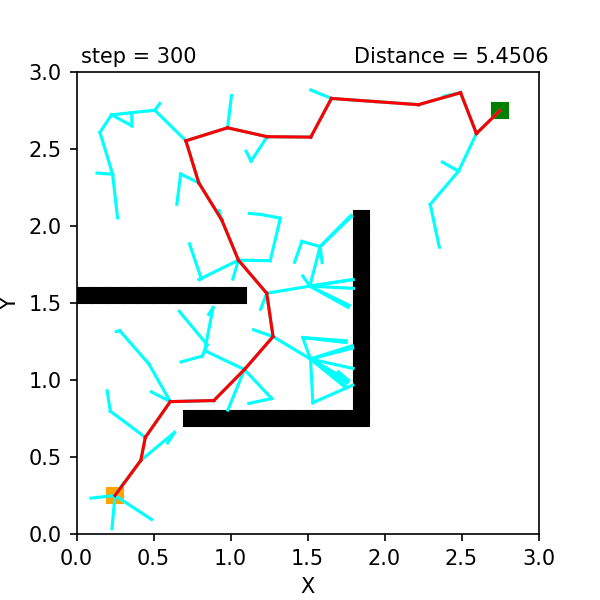

In [3]:
if __name__ == "__main__":
    time_span = 30
    time_interval = 0.1
    
    grid_step = np.array([0.1, 0.1])
    grid_num = np.array([30, 30])
    
    map_data = "../csvmap/map4.csv"
    
    world = GridMapWorld(grid_step, grid_num, time_span, time_interval, map_data, debug=False)
    world.append(RRT(world, ratioPointGoal=0.95))
    
    world.draw()
    #world.ani.save('input.gif', writer='pillow', fps=100)    #アニメーション保存